In [1]:
# Group number: 14
# Veerle Schepers s1023102
# Angeliki-Ilektra Karaiskou, s1029746
# Lei Xiaoxuan, s1025681
# Parsia Basimfar : s1022274

In [2]:
import scipy
from scipy import stats
from scipy.io import loadmat
import pandas as pd
import numpy as np
from pandas import DataFrame
import chainer
import chainer.functions as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.links as L
from chainer.training import extensions
from chainer.backends.cuda import to_cpu
from chainer.dataset import concat_examples
from chainer.datasets import TupleDataset

#import cupy as cp

**SOW-MKI49: Neural Information Processing Systems**

**Assignment 5: Neural Decoding**

**Total points: 100**

**Author: Umut**

In this assignment, you will implement a neural decoder for reconstructing perceived stimuli from brain responses. We will be using the dataset that was previously used in a number of papers. These papers along with additional lecture notes on neural decoding can be found in Brightspace. You can refer them for more details on the dataset and/or the method.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** -> This is a 100 x 784 matrix. The ith row contains the pixel values of the stimulus that was presented in the ith trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** -> This is a 100 x 3092 matrix. The ith row contains the voxel values of the responses that were measured in the ith trial of the experiment.

* **X_prior** -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.

## Task 1 (10 points)

* Load the dataset.
* Visualize some of the stimuli.
* Normalize X and Y to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean of each pixel/voxel from itself and dividing it by its standard deviation. You can use zscore function.
* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

(100, 784)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


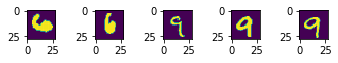

In [3]:
###
# Load the dataset
dataset = loadmat('69dataset2.mat')

# get the stimuli
x_data = dataset['X']
print(x_data.shape)
y_data = dataset['Y']
x_prior_data = dataset['X_prior']
# convert stimuli to array
x_dat = np.array(x_data)
y_dat = np.array(y_data)
x_prior_dat = np.array(x_prior_data)


# convert stimuli 0, 25, 50, 75 and 99 to a 28x28 numpy array
x_0  = np.reshape(x_dat[0],[28,28],order='F')
x_25 = np.reshape(x_dat[25],[28,28],order='F')
x_50 = np.reshape(x_dat[50],[28,28],order='F')
x_75 = np.reshape(x_dat[75],[28,28],order='F')
x_99 = np.reshape(x_dat[99],[28,28],order='F')

###
# show some input stimuli
plt.subplot(1,10,1)
plt.imshow(x_0 )
plt.subplot(1,10,3)
plt.imshow(x_25 )
plt.subplot(1,10,5)
plt.imshow(x_50 )
plt.subplot(1,10,7)
plt.imshow(x_75 )
plt.subplot(1,10,9)
plt.imshow(x_99 )

# save some input stimuli
plt.imsave('x_0.png', x_0)
plt.imsave('x_25.png', x_25)
plt.imsave('x_50.png', x_50)
plt.imsave('x_75.png', x_75)
plt.imsave('x_99.png', x_99)

###
# Normalize X and Y to have zero mean and unit variance. 
# Tip: Recall that normalization means 
# subtracting the mean of each pixel/voxel from itself --> dat - dat.mean()
# and dividing it by its standard deviation. --> dat_std
# You can use zscore function.

###
# normalize X
# mean is not zero... are we doing something wrong?
# print("x_dat mean =", x_dat.mean())

# reshape to don't get weird errors in math functions
# compute normalized values
# x_dat2  = np.reshape(x_dat,[78400])

x_dat_mean = np.mean(x_dat,0)[None]
x_dat_std = np.std(x_dat,0)[None]
x_dat_norm = (x_dat - x_dat_mean) / (x_dat_std)
x_dat_norm2 = scipy.stats.mstats.zscore(x_dat,axis=None)
where_are_NaNs = np.isnan(x_dat_norm)
x_dat_norm[where_are_NaNs] = 0


###
# Normalize Y

# print("y_dat mean =", (y_dat.mean())) 

# reshape to don't get weird errors in math functions
# compute normalized values
# y_dat2  = np.reshape(y_dat,[309200])
y_dat_std = np.std(y_dat,0)[None]
y_dat_norm = (y_dat - np.mean(y_dat,0)[None])/ (y_dat_std)
y_dat_norm2 = scipy.stats.mstats.zscore(y_dat, axis = None)


###
# Normalize X_prior

# x_prior_dat2  = np.reshape(x_prior_dat,[1568000])
x_prior_dat_std = np.std(x_prior_dat,0)[None]
x_prior_dat_norm = (x_prior_dat - np.mean(x_prior_dat,0)[None]) / (x_prior_dat_std)


where_are_NaNs = np.isnan(x_prior_dat_norm)
x_prior_dat_norm[where_are_NaNs] = 0


###
# Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. 
# The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines).
# The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

## do we need to use dat_norm ?

### X 
# use the first 40 6's (0-39) and first 40 9's (50-89) for the training set [0:40] takes 0:39
# combine these 2 sets with np.concatenate

# Train
x_train_6 = x_dat_norm[0:40]
x_train_9 = x_dat_norm[50:90]
x_train = np.concatenate((x_train_6, x_train_9), axis=0)

# Test
x_test_6 = x_dat_norm[40:50]
x_test_9 = x_dat_norm[90:100]
x_test = np.concatenate((x_test_6, x_test_9), axis=0)

### Y
# Train
y_train_6 = y_dat_norm[0:40]
y_train_9 = y_dat_norm[50:90]
y_train = np.concatenate((y_train_6, y_train_9), axis=0)

# Test
y_test_6 = y_dat_norm[40:50]
y_test_9 = y_dat_norm[90:100]
y_test = np.concatenate((y_test_6, y_test_9), axis=0)


Our goal is to solve the problem of reconstructing **x** from **y**. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict **x** as a function of **y**. That is:

**x** = f(**y**)

We will assume that f is a linear function. That is:

**x** = **B'** **y**

f can be seen as a very simple linear neural network comprising one layer of weights (i.e., **B**). We can estimate **B** in close form with ridge regression. That is:

**B** = inv(**Y**\_training' **Y**\_training + lambda **I**) **Y**\_training' **X**\_training

where lambda is the regularization coefficient, **I** is the *q* x *q* identity matrix, and *q* is the number of voxels. Note that we can safely ignore the intercept since we normalized our data to have zero mean and unit variance.

## Task 2  (15 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross validation to estimate lambda. For simplicity, you can assume that lambda = 10 ^ -6.
* Reconstruct **x** from **y** in the test set.
* Visualize the reconstructions.

(784, 3092)


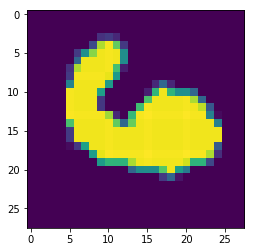

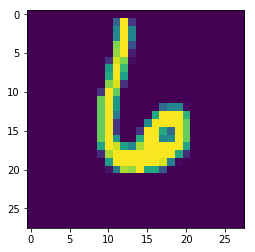

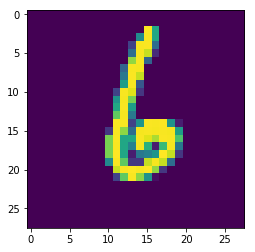

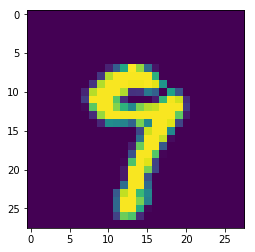

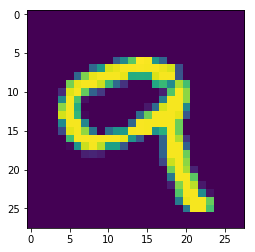

<Figure size 432x288 with 0 Axes>

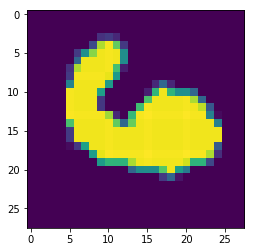

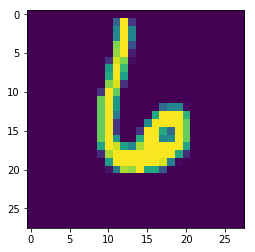

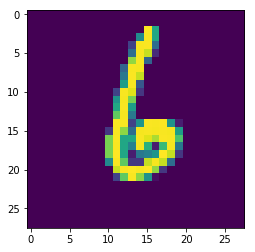

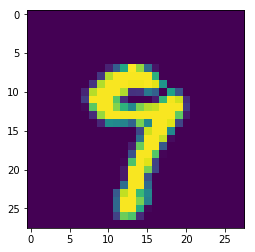

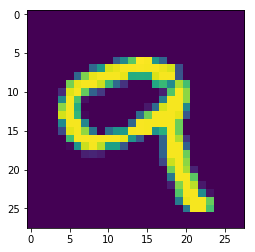

In [4]:
from numpy.linalg import inv

###
# Estimate B on the training set.

# B = inv(Y_training' * Y_training + lambda * eye(q)) \ Y_training' * X_training
# B^= (y_train^T * y_train + lam* I*)^(-1) \ y_train^T * x_train
# I* = eye(q) = an q-by-q identity matrix with ones on the main diagonal and zeros elsewhere.

# Y_training' = y_train^T = y_train_T = transpose y_train

# given variables
q = len(y_dat[0])
lam = 10**-6

# compute other variables
I_q = np.eye(q)
y_train_T = y_train.transpose()

# Compute B
temp1 = np.matmul(y_train_T,y_train) # y_train^T * y_train
temp2 = lam * I_q # lambda * I
part1 = (temp1 + temp2) # inv(y_train^T * y_train + lambda * I)
part2 = np.matmul(y_train_T,x_train) # y_train_T * x_train
B = np.linalg.solve(part1,part2) # inv(y_train^T * y_train + lambda * I) /  y_train_T * x_train


###
# Reconstruct x** from **y in the test set.
# x** = **B' y
# x_train[x] = B^T * y_train

# Transpose B
B_T = B.transpose()
print(B_T.shape)
x_recon = B_T.dot(y_train_T)
x_recon = x_recon.transpose()

###
# Visualize the reconstructions
#x = reshape(X(i, :) .* sigma + mu, 28, 28);
# reshape the reconstructed x's
x_recon_0  = np.reshape(np.multiply(x_recon[0],x_dat_std)+x_dat_mean,[28,28],order='F')
x_recon_19  = np.reshape(np.multiply(x_recon[19],x_dat_std)+x_dat_mean,[28,28],order='F')
x_recon_39  = np.reshape(np.multiply(x_recon[39],x_dat_std)+x_dat_mean,[28,28],order='F')
x_recon_59  = np.reshape(np.multiply(x_recon[59],x_dat_std)+x_dat_mean,[28,28],order='F')
x_recon_79  = np.reshape(np.multiply(x_recon[79],x_dat_std)+x_dat_mean,[28,28],order='F')

# show the reconstructed x's 
plt.figure()
plt.imshow(x_recon_0 )
plt.figure()
plt.imshow(x_recon_19 )
plt.figure()
plt.imshow(x_recon_39 )
plt.figure()
plt.imshow(x_recon_59 )
plt.figure()
plt.imshow(x_recon_79 )

# save the reconstructed x's
plt.imsave('x_recon_0.png', x_recon_0)
plt.imsave('x_recon_19.png', x_recon_19 )
plt.imsave('x_recon_39.png', x_recon_39 )
plt.imsave('x_recon_59.png', x_recon_59 )
plt.imsave('x_recon_79.png', x_recon_79 )



### show multiple figures
# to check if they are different
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure()
#fig.add_subplot(5,1,1)
plt.figure()
plt.imshow(x_recon_0 )

plt.figure()
plt.imshow(x_recon_19 )
plt.figure()

plt.imshow(x_recon_39 )
plt.figure()

plt.imshow(x_recon_59 )
plt.figure()

plt.imshow(x_recon_79 )


import matplotlib.pyplot as plt




Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

where P(**x** | **y**) is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)

where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the likelihood and the prior are multivariate Gaussian distributions. A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the likelihood, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

where lambda is the regularization coefficient, I is the *p* x *p* identity matrix, and *p* is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]). 

In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

where n is the length of **X**\_prior.

## Task 3 (20 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, you can assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.
* Estimate **Sigma**\_prior. Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.
* Visualize **Sigma**\_prior. Can you explain what it shows?

(784, 3092)


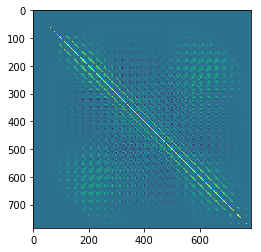

In [5]:
###
# Estimate B** on the training set.
#B = inv(X_training' X_training + lambda I) X_training' Y_training
# mu_likelihood = B' x
x_train_T = x_train.transpose()
mu_likelihood = np.matmul(B,x_train_T) # B'x
p = len(x_dat[0]) # number of pixels = 28*28 = 784

I_p = np.eye(p) 

Sigma_likelihood = 10**-3* I_q # size 3092X3092

# compute B
#B               = (X_training' * X_training + lambda * eye(p)) \  X_training' * Y_training;
#   
B_gen_temp1 = np.matmul(x_train_T,x_train) # X_training' **X_training
B_gen_temp2 = lam * I_p #  lambda I*
B_gen_part2 = np.matmul(x_train_T,y_train) # X_training' Y_training
B_gen2 = np.linalg.solve(B_gen_temp1 + B_gen_temp2, B_gen_part2)
print(B_gen2.shape)

# B** = inv(X_training' **X_training + lambda I*) *X_training' Y_training

###
# Estimate Sigma_prior
# Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.

# Sigma_prior = X*_prior' * *X_prior / (n - 1)
# where n is the length of X_prior.
n = len(x_prior_dat[0])

x_prior = x_prior_dat_norm
x_prior_T = x_prior.transpose()

Sigma_temp1 = x_prior_T.dot(x_prior)
Sigma_temp2 = (n - 1)
Sigma_temp3 = Sigma_temp1 / Sigma_temp2



Sigma_prior = Sigma_temp3 + lam * I_p

### Visualize Sigma_prior. 
### Can you explain what it shows?


plt.imshow(Sigma_prior)
plt.imsave('Sigma_prior.png', Sigma_prior)

###
# Sigma_prior, in the linear Gaussian case, 
# is the required covariance matrix for the prior R
# R = 1 (N-1) * sum(z^n*(z^n)^T)
# Schoenmakers (2013)

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

**mu**\_posterior = inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?

.  
.  
.  
.  
.  
.

The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.


## Task 4 (25 points)

- Reconstruct **x** from **y** in the test set.
- Visualize the reconstructions.
- Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results?

(20, 784)
(784, 20)
(28, 28)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

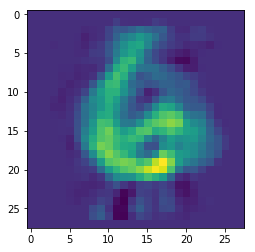

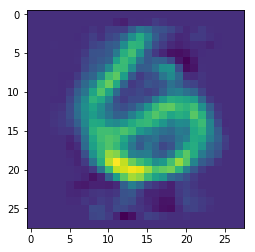

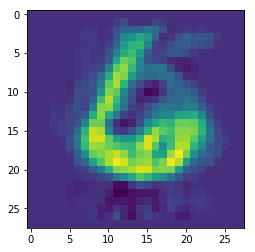

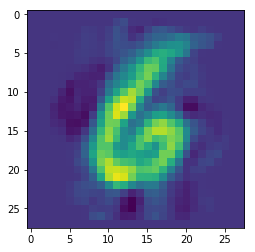

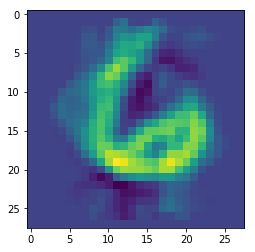

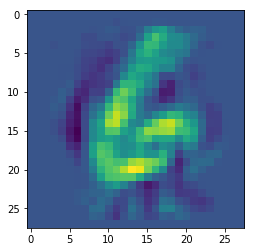

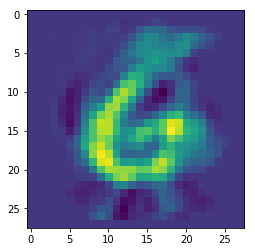

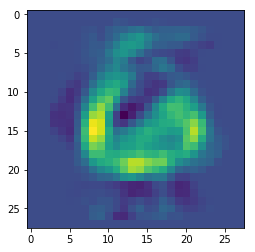

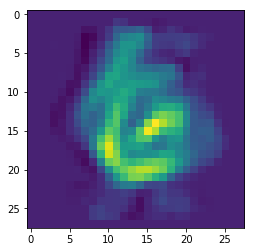

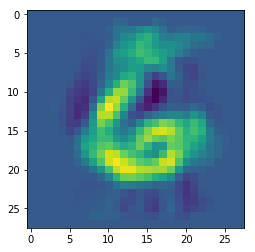

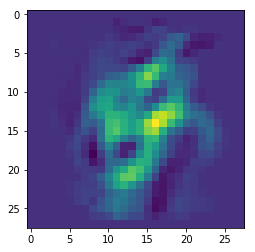

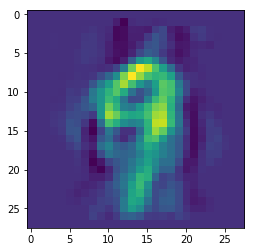

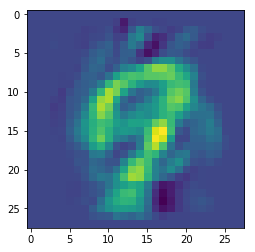

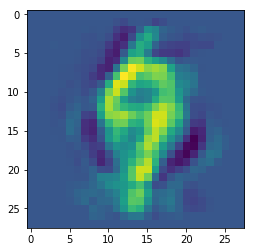

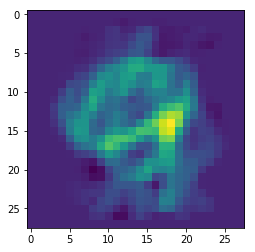

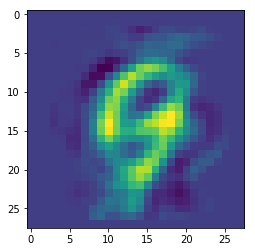

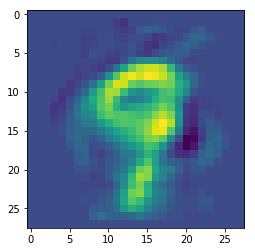

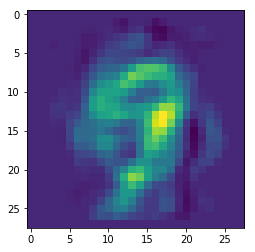

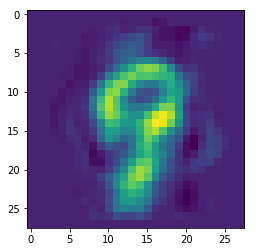

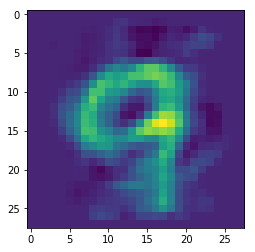

In [7]:

inv_sig_prior = np.linalg.inv(Sigma_prior) # inv(Sigma_prior)
B_gen2_T = B_gen2.T
#B inv(Sigma_likelihood) B'
B_Sl_BT=np.matmul(np.linalg.solve(Sigma_likelihood.T, B_gen2.T).T,B_gen2.T)
arg_inv=inv_sig_prior+B_Sl_BT
arg2=np.linalg.solve( Sigma_likelihood.T,B_gen2.T).T
arg3=np.linalg.solve(arg_inv,arg2)
final=np.matmul(arg3,y_test.T)



x_test_recon = final.T
print(x_test_recon.shape)
x_test_recon_T = x_test_recon.transpose()
print(x_test_recon_T.shape)


###
# Visualize the reconstructions.

# reshape the reconstructed x's
x_test_recon_0  = np.reshape(np.multiply(x_test_recon[15],x_dat_std)+x_dat_mean,[28,28],order='F')
x_test_recon_4  = np.reshape(np.multiply(x_test_recon[4],x_dat_std)+x_dat_mean,[28,28],order='F')
x_test_recon_9  = np.reshape(np.multiply(x_test_recon[10],x_dat_std)+x_dat_mean,[28,28],order='F')
x_test_recon_14  = np.reshape(np.multiply(x_test_recon[14],x_dat_std)+x_dat_mean,[28,28],order='F')
x_test_recon_19  = np.reshape(np.multiply(x_test_recon[19],x_dat_std)+x_dat_mean,[28,28],order='F')
plt.figure()
print(x_test_recon_0.shape)
#fig=plt.figure()
for i in range(0,20):
# show the reconstructed x's 
    plt.figure()
    x_test_recon_=np.reshape(np.multiply(x_test_recon[i],x_dat_std)+x_dat_mean,[28,28],order='F')
    plt.imshow(x_test_recon_)
    
#plt.show()

# save the reconstructed x's
plt.imsave('x_test_recon_0.png', x_test_recon_0 )
plt.imsave('x_test_recon_4.png', x_test_recon_4 )
plt.imsave('x_test_recon_9.png', x_test_recon_9 )
plt.imsave('x_test_recon_14.png', x_test_recon_14 )
plt.imsave('x_test_recon_19.png', x_test_recon_19 )


###
# Compare the reconstructions with the earlier reconstructions. 
# Which one is better? Why? Can you think of ways to improve the results?


# The earlier version was better. This is logical since it is trained on the 80 train-sets instead of the 20 test-sets
# Improvement can be done by using the larger test-set to learn and then test it on the smaller test-set

Now the real fight begins! You might have already realized that the second approach is very similar to the one in the face reconstruction paper that we have discussed in the last lecture. The main difference is how the stimuli are encoded. So far, we have been encoding the stimuli with an identity transformation:

**mu**\_likelihood = **B'** g(**x**)

where g(**x**) = **x**

In the paper, they are encoded as the features extracted from a DNN:

**mu**\_likelihood = **B'** DNN(**x**)

Similarly, we have been decoding the responses with MAP estimation of the stimuli:

g ^ -1(argmax_g(**x**) P(g(**x**) | **y**))

where g ^ -1(**y**) = **y**

In the paper, they are decoded with MAP estimation of the features followed by an inverse DNN:

DNN ^ -1(argmax_DNN(**x**) P(DNN(**x**) | **y**))

## Task 5 (30 points)

- Train a simple DNN for digit classification on the MNIST dataset.
- Select an indermediate layer of the DNN as your feature extractor.
- Train another simple DNN to invert the first DNN. That is, it should transform features extracted by the selected layer of the first DNN to stimuli.
- Repeat Task 3 but use the trained DNNs instead of identity transformation.

In [8]:
batchsize = 128
max_epoch = 10
## we are doing digit classification instead of construting the brain stimuli
train, test = chainer.datasets.mnist.get_mnist(withlabel=True, ndim=3)
from chainer import iterators, dataset

In [9]:
[train_temp,temp] = dataset.concat_examples(train)
[test_temp,temp] = dataset.concat_examples(test)

In [12]:
# create a dataset iterator
train_iter = iterators.SerialIterator(train,batchsize)
test_iter = iterators.SerialIterator(test,batchsize,repeat = False, shuffle=False)

In [13]:
class DNN(chainer.Chain):
    def __init__(self):
        super(DNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 8, ksize=3)
            self.conv2 = L.Convolution2D(None, 16, ksize=3)
            self.l3 = L.Linear(None, 32)
            self.l4 = L.Linear(None, 10)
            
    def __call__(self, x):
        
        h1 = self.conv1(x)
        h1 = F.relu(h1)
        h2 = self.conv2(h1)
        h2 = F.relu(h2)
        h3 = self.l3(h2)
        h3 = F.relu(h3)
        h4 = self.l4(h3)
        #h4 = F.relu(h4)
        return h4

    def extract(self, x, layer_name=None):
        
        if layer_name is None:
            IOError('abort!')

        if layer_name == 'conv1':
            h1 = self.conv1(x)
            h1 = F.relu(h1)
            return h1
        
        elif layer_name == 'conv2':
            h1 = self.conv1(x)
            h1 = F.relu(h1)
            h2 = self.conv2(h1)
            h2 = F.relu(h2)
            return h2
        
        elif layer_name == 'l3':
            h1 = self.conv1(x)
            h1 = F.relu(h1)
            h2 = self.conv2(h1)
            h2 = F.relu(h2)
            h3 = self.l3(h2)
            h3 = F.relu(h3)
            return h3
        
        elif layer_name == 'l4':
            h1 = self.conv1(x)
            h1 = F.relu(h1)
            h2 = self.conv2(h1)
            h2 = F.relu(h2)
            h3 = self.l3(h2)
            h3 = F.relu(h3)
            h4 = self.l4(h3)
            #h4 = F.relu(h4)
            return h4

In [14]:
model = DNN()

gpu_id = -1
if gpu_id >= 0:
    model.to_gpu(gpu_id)
else:
    model.to_cpu()

In [15]:
optimizer = optimizers.Adam(alpha=0.1)
optimizer.setup(model)

# loss function: softmax_cross_entropy()
while train_iter.epoch < max_epoch:
    # iteration of the training loop
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch,gpu_id)
    
    prediction_train = model(image_train)
    
    loss = F.softmax_cross_entropy(prediction_train,target_train)
    
    model.cleargrads()
    loss.backward()
    
    optimizer.update()
    
    # check the validation accuracy of predictions after every epoch
    if train_iter.is_new_epoch:
        # show the training loss
        print('epoch:{:02d} train_loss:{:.04f}'.format(train_iter.epoch,float(to_cpu(loss.data))),end='')
        
        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test,target_test = concat_examples(test_batch,gpu_id)
            prediction_test = model(image_test)
            loss_test = F.softmax_cross_entropy(prediction_test,target_test)
            test_losses.append(to_cpu(loss_test.data))
            
            accuracy = F.accuracy(prediction_test,target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)
            
            if test_iter.is_new_epoch:
                test_iter.epoch=0
                test_iter.current_position=0
                test_iter.is_new_epoch=False
                test_iter._pushed_position = None
                break
        print('Val_loss:{:.04f} val_accuracy:{:.04f}'.format(np.mean(test_losses),np.mean(test_accuracies)))

epoch:01 train_loss:2.2968Val_loss:2.3039 val_accuracy:0.1136
epoch:02 train_loss:2.3067Val_loss:2.3040 val_accuracy:0.1136
epoch:03 train_loss:2.2908Val_loss:2.3098 val_accuracy:0.1136
epoch:04 train_loss:2.3061Val_loss:2.3030 val_accuracy:0.0970
epoch:05 train_loss:2.3040Val_loss:2.3037 val_accuracy:0.0961
epoch:06 train_loss:2.2983Val_loss:2.3054 val_accuracy:0.1136
epoch:07 train_loss:2.2954Val_loss:2.3130 val_accuracy:0.0961
epoch:08 train_loss:2.3080Val_loss:2.3063 val_accuracy:0.1024
epoch:09 train_loss:2.3012Val_loss:2.3054 val_accuracy:0.0961
epoch:10 train_loss:2.3031Val_loss:2.3130 val_accuracy:0.1024


In [16]:
# save the model
serializers.save_npz('DNN_MNIST_model_3.npz',model)

label: 5
preticted label: 7


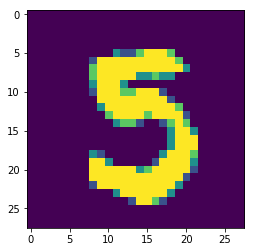

In [17]:
import matplotlib.pyplot as plt
## perform the DNN classification model
dnn_model = DNN()
serializers.load_npz('DNN_MNIST_model_3.npz',dnn_model)
# get a test image and label
x,t = test[5964]
plt.imshow(x.reshape(28,28))
print('label:',t)
# use the model
x = x[None,...]
y = dnn_model(x)
y = y.data
# look for the most probable digit number using argmax
prediction_label = y.argmax(axis=1)
print("preticted label:",prediction_label[0])

In [18]:
## select an intermediate layer
layer_name = 'conv2'
#layer_name = 'l3'
#layer_name = 'L2'
# how to extract latent feature
# how to extract the corresponding latent feature of all stimuli???
num_tr=len(train_temp)
num_test=len(test_temp)
print('num_tr =', num_tr)
print('num_test =',num_test)

latent_feature_tr = []
latent_feature_te = []
i=0

for img_tr in train_temp[:num_tr]:
    
    latent_feature_tr.append(dnn_model.extract(np.expand_dims(img_tr, axis=0), layer_name=layer_name).data)

for img_te in test_temp[:num_test]:
    latent_feature_te.append(dnn_model.extract(np.expand_dims(img_te, axis=0), layer_name=layer_name).data)
    
    

num_tr = 60000
num_test = 10000


In [19]:
print(train_temp.shape)

(60000, 1, 28, 28)


In [20]:
latent_feature_tr_n = latent_feature_tr
latent_feature_te_n  = latent_feature_te
latent_feature_tr = np.array(latent_feature_tr)
latent_feature_te = np.array(latent_feature_te)


inv_train = TupleDataset(latent_feature_tr, train_temp[:num_tr])
inv_test = TupleDataset(latent_feature_te,test_temp[:num_test])

In [21]:
## invert dnn
# input: latent_feature
# output: image/stimuli 28*28

# 

class invert_DNN(chainer.Chain):
    def __init__(self):
        super(invert_DNN,self).__init__()
        with self.init_scope():

            self.l0 = L.Linear(None, 128)
            self.l1 = L.Linear(128, 300)
            self.l2 = L.Linear(300,500)
            self.l3 = L.Linear(500,784)

    def __call__(self,x):
  
        h1 = self.l0(x)
        h1 = F.relu(h1)
        h5 = self.l1(h1)
        h5 = F.relu(h5)
        h6 = self.l2(h5)
        h6 = F.relu(h6)
        h7 = self.l3(h6)
        h7 = F.sigmoid(h7)

        return h7

In [22]:
# traning of the new DNN
import IPython
batchsize = 50
gpu_id = -1
inv_train_iter = iterators.SerialIterator(inv_train,batchsize,repeat = False, shuffle=False)
inv_test_iter = iterators.SerialIterator(inv_test,batchsize,repeat = False, shuffle=False)


inv_model = invert_DNN()
inv_model.to_cpu()
inv_optimizer = optimizers.SGD(lr=0.5)
inv_optimizer.setup(inv_model)
dnn_model.disable_update()

loss_history = {'training': [],'validation' : []}
#loss_history = []


In [23]:
epochs =100
for i in range(epochs):
    loss_history['training'].append(0)
    loss_history['validation'].append(0)
    inv_train_iter.reset()
    #validation_iterator.reset()
    for j, batch in enumerate(inv_train_iter):
        with chainer.using_config('train', True):
            # print('j = ', j)
            #inv_model.cleargrads()
            feature_train, stimuli_train = concat_examples(batch,-1)
            x=chainer.Variable(feature_train)
            stimuli_train=chainer.Variable(np.reshape(stimuli_train,[batchsize,784]))

            predicted = inv_model(x)

            
            loss = F.mean_squared_error(predicted,stimuli_train)
            inv_model.cleargrads()
            loss.backward()

            inv_optimizer.update()
        
            loss_history['training'][-1] += float(loss.data)
            #loss_history['training'].append(float(loss.data))
            #print(float(loss.data))
    loss_history['training'][-1] /= j + 1
    
    #loss_history['validation'].append(0)


    for j1, batch1 in enumerate(inv_test_iter):
        with chainer.using_config('train', False):
            feature_train1, stimuli_train1 = concat_examples(batch1,-1)
            x1=chainer.Variable(feature_train1)
            stimuli_train1=chainer.Variable(np.reshape(stimuli_train1,[batchsize,784]))
            #x1 = chainer.Variable(dataset.concat_examples(batch1))
            predicted1 = inv_model(x1)


            loss = F.mean_squared_error(predicted1,stimuli_train1)

            #loss = loss_fn(mean_z1, ln_var_z1,x1, mean_x1, ln_var_x1)
            inv_model.cleargrads()
            loss.backward()

            inv_optimizer.update()
            loss_history['validation'][-1] += float(loss.data)
    loss_history['validation'][-1] /= j1 + 1
    
    print("iteration i = ")
    print(i)
    print("is ended and we are going to the next one")
    print("-------------------------------------------")
    #print('epoch: {:3d} / {:03d}, training loss: {:.4f} , validation loss: {:.4f}.'.format(i + 1, epochs, loss_history ['training'][i], loss_history['validation'][i]))
    print('epoch: {:3d} / {:03d}, training loss: {:.4f} '.format(i + 1, epochs, loss_history ['training'][i]))
np.savez('{:s}loss_history_{:03d}.npz'.format('', epochs), loss_history)
serializers.save_npz('group14_invDNN_50epochs_V1.model', inv_model)

serializers.save_npz('{:s}optimizer_{:03d}.npz'.format('', epochs), inv_optimizer)

iteration i = 
0
is ended and we are going to the next one
-------------------------------------------
epoch:   1 / 100, training loss: 0.2166 
iteration i = 
1
is ended and we are going to the next one
-------------------------------------------
epoch:   2 / 100, training loss: 0.1873 
iteration i = 
2
is ended and we are going to the next one
-------------------------------------------
epoch:   3 / 100, training loss: 0.1675 
iteration i = 
3
is ended and we are going to the next one
-------------------------------------------
epoch:   4 / 100, training loss: 0.1518 
iteration i = 
4
is ended and we are going to the next one
-------------------------------------------
epoch:   5 / 100, training loss: 0.1393 
iteration i = 
5
is ended and we are going to the next one
-------------------------------------------
epoch:   6 / 100, training loss: 0.1293 
iteration i = 
6
is ended and we are going to the next one
-------------------------------------------
epoch:   7 / 100, training loss: 

<class 'dict'>


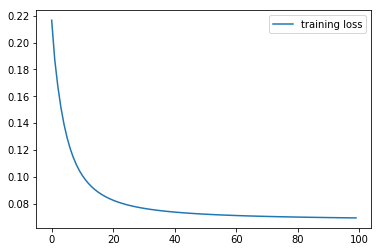

In [24]:
print(type(loss_history))
train = plt.plot(np.arange(100), loss_history['training'], label = 'training loss')

plt.legend(['training loss'])

In [25]:
dnn=DNN()
serializers.load_npz('DNN_MNIST_model_3.npz',dnn)
inv_DNN = invert_DNN()
serializers.save_npz('group14_invDNN_50epochs_V1.model',inv_DNN)

## select an intermediate layer
layer_name = 'conv2'
#layer_name = 'l3'
#layer_name = 'L2'
# how to extract latent feature
# how to extract the corresponding latent feature of all stimuli???
num_tr=len(x_train)
num_test=len(x_test)
num_prior=len(x_prior)

x_feat_train = []
x_feat_test = []
x_feat_prior = []

x_prior_n = np.reshape(x_prior,[num_prior,1,28,28])
x_prior_n = x_prior_n.astype(np.float32)

x_train_n = np.reshape(x_train,[num_tr,1,28,28])
x_train_n = x_train_n.astype(np.float32)

x_test_n = np.reshape(x_test,[num_test,1,28,28])
x_test_n = x_test_n.astype(np.float32)



for img_tr in x_train_n[:num_tr]:
    x_feat_train.append(dnn.extract(np.expand_dims(img_tr, axis=0), layer_name=layer_name).data)

for img_te in x_test_n[:num_test]:
    x_feat_test.append(dnn.extract(np.expand_dims(img_te, axis=0), layer_name=layer_name).data)
    
for img_prior in x_prior_n[:num_prior]:
    x_feat_prior.append(dnn.extract(np.expand_dims(img_prior, axis=0), layer_name=layer_name).data)   
    
x_feat_train_n = x_feat_train
x_feat_test_n  = x_feat_test
x_feat_prior_n = x_feat_prior
x_feat_train = np.array(x_feat_train)
x_feat_test = np.array(x_feat_test)
x_feat_prior = np.array(x_feat_prior)

print(x_feat_train[0].shape)
arithmos=x_feat_train[0].shape
print(arithmos)
"""inv_x_train = TupleDataset(x_feat_train, x_train_n[:num_tr])
inv_x_test = TupleDataset(x_feat_test,x_test_n[:num_test])   """


(1, 16, 24, 24)
(1, 16, 24, 24)


'inv_x_train = TupleDataset(x_feat_train, x_train_n[:num_tr])\ninv_x_test = TupleDataset(x_feat_test,x_test_n[:num_test])   '

In [26]:
print(np.reshape(x_feat_train,[80,-1]).shape)

(80, 9216)


In [27]:
#print(inv_x_train[0].type)
xf_train = np.reshape(x_feat_train,[80,-1])
xf_trainT = xf_train.transpose()
#print(xf_train.shape,xf_trainT.shape)
xf_prior = np.reshape(x_feat_prior,[len(x_prior),-1])
xf_priorT = xf_prior.transpose()
#print(xf_prior.shape,xf_priorT.shape)
#import sys
#print (sys.maxsize)

In [28]:
#mu_likelihood = np.matmul(B,x_train_T) # B'x
p = len(xf_train[0]) # number of pixels = 28*28 = 784

I_p = np.eye(p) 

Sigma_likelihood = 10**-3* I_q # size 3092X3092

# compute B
#B               = (X_training' * X_training + lambda * eye(p)) \  X_training' * Y_training;
#   
B_gen_temp1 = np.matmul(xf_trainT,xf_train) # X_training' **X_training
B_gen_temp2 = lam * I_p #  lambda I*
B_gen_part2 = np.matmul(xf_trainT,y_train) # X_training' Y_training
#print(B_gen_temp1.shape,B_gen_temp2.shape,B_gen_part2.shape)

In [29]:
B_gen2 = np.linalg.solve(B_gen_temp1 + B_gen_temp2, B_gen_part2)
#print(B_gen2.shape)

# B** = inv(X_training' **X_training + lambda I*) *X_training' Y_training

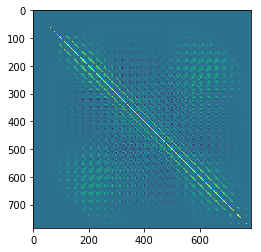

In [30]:
###
# Estimate Sigma_prior
# Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.

# Sigma_prior = X*_prior' * *X_prior / (n - 1)
# where n is the length of X_prior.
nf = len(xf_prior[0])
#print(nf)
#print(xf_priorT.shape,xf_prior.shape)
Sigma_tempf1 = xf_priorT.dot(xf_prior)
Sigma_tempf2 = (nf - 1)
Sigma_tempf3 = Sigma_tempf1 / Sigma_tempf2

Sigma_priorf = Sigma_tempf3 + lam * I_p

plt.imshow(Sigma_prior)
plt.imsave('Sigma_prior.png', Sigma_prior)

In [31]:
inv_sig_prior = np.linalg.inv(Sigma_priorf) # inv(Sigma_prior)
B_gen2_T = B_gen2.T
#B inv(Sigma_likelihood) B'
B_Sl_BT=np.matmul(np.linalg.solve(Sigma_likelihood.T, B_gen2.T).T,B_gen2.T)
arg_inv=inv_sig_prior+B_Sl_BT
arg2=np.linalg.solve( Sigma_likelihood.T,B_gen2.T).T
arg3=np.linalg.solve(arg_inv,arg2)
final=np.matmul(arg3,y_test.T)

In [32]:
x_test_recon_f = final.T
print(x_test_recon_f.shape)
x_test_recon_f_T = x_test_recon_f.transpose()
print(x_test_recon_f_T.shape)

(20, 9216)
(9216, 20)


In [33]:
#print(np.reshape(x_test_recon_f,[20, 1, 32]).shape) #linear layer
x_test_recon_f = np.reshape(x_test_recon_f,[20, 1, 16, 24, 24]).astype(np.float32) #conv2 layer
#x_test_recon_f = np.reshape(x_test_recon_f,[20, 1, 32]).astype(np.float32) # l1

In [34]:
print(x_test_recon_f[0].shape)
print(x_test_recon_f[0].dtype)

(1, 16, 24, 24)
float32


In [35]:
x_test_recon_final=[]
for img_feat in range(len(x_test_recon_f)):
    
    x=chainer.Variable(x_test_recon_f[img_feat])
    #print(x)
    predicted = inv_DNN(x)
    x_test_recon_final.append(np.array(predicted.data).astype(np.float64))

x_test_recon_final=np.array(x_test_recon_final)

(20, 1, 784)


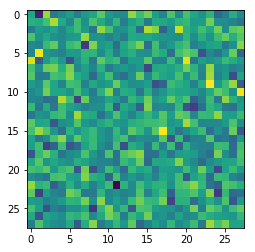

In [36]:
print(x_test_recon_final.shape)
plt.figure()
#x_test_recon_0  = np.reshape(np.multiply(x_test_recon_final[7],x_dat_std)+x_dat_mean,[28,28],order='F')
x_test_recon_0  = np.reshape(x_test_recon_final[7],[28,28],order='F')
plt.imshow(x_test_recon_0)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


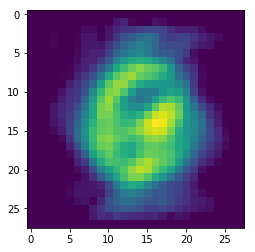

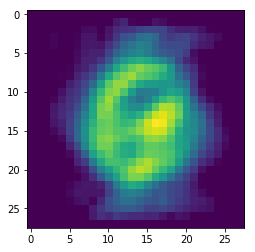

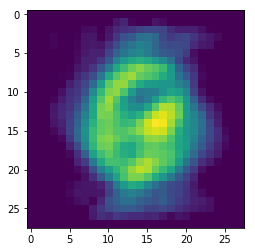

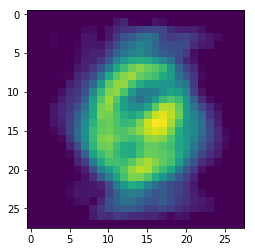

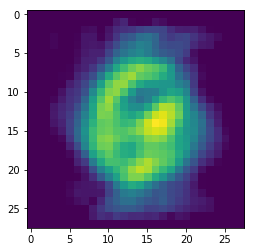

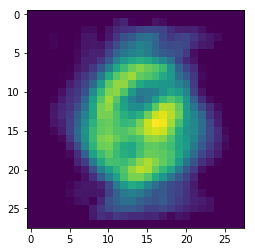

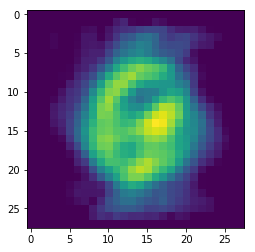

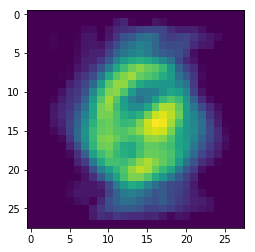

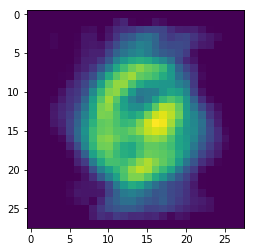

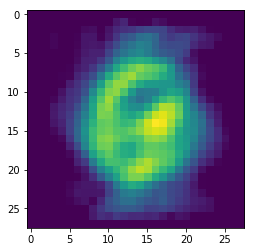

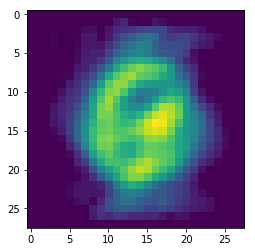

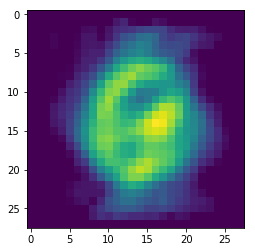

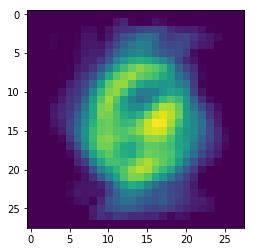

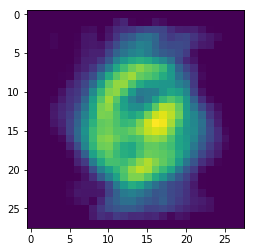

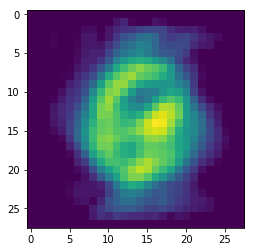

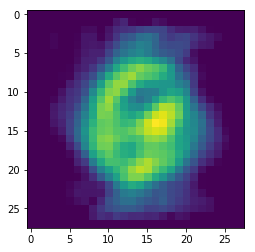

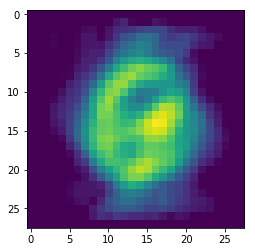

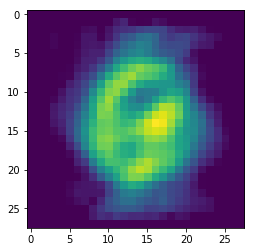

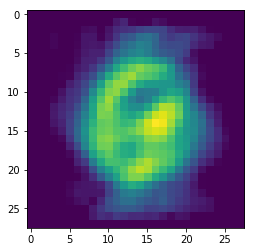

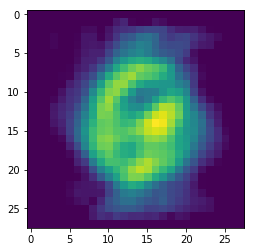

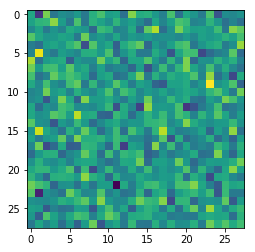

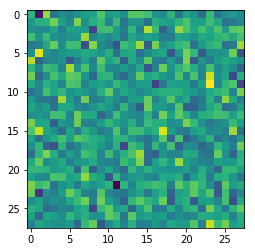

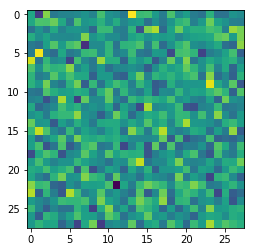

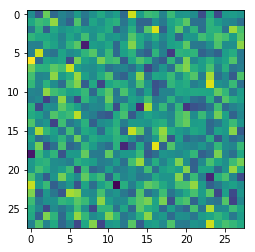

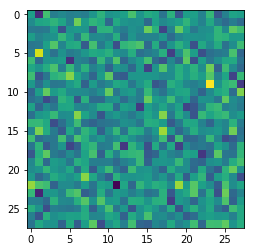

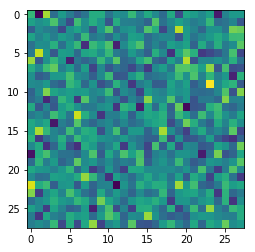

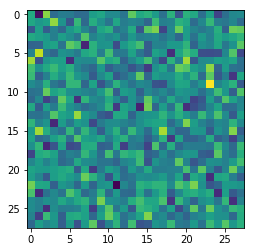

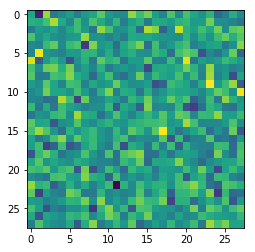

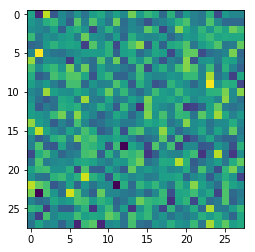

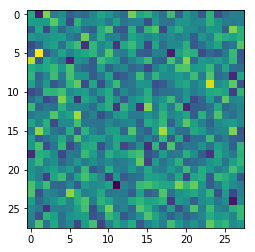

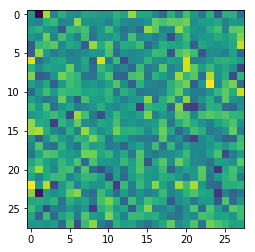

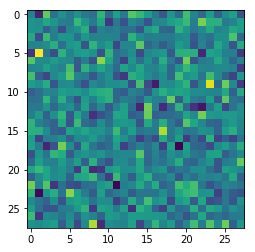

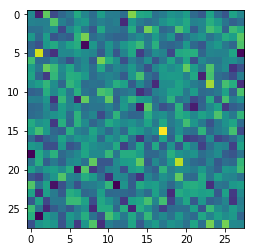

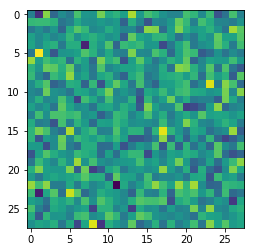

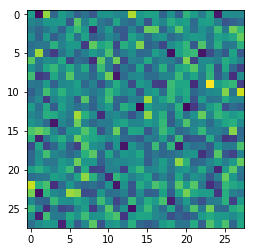

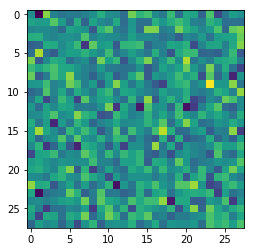

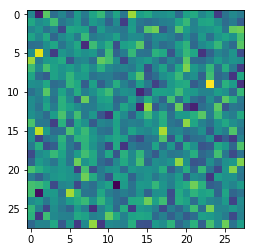

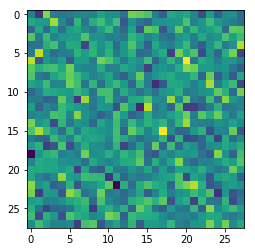

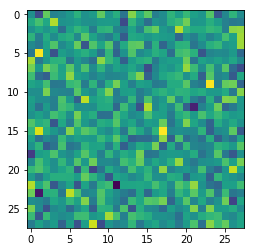

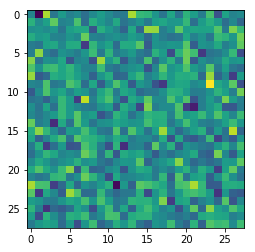

In [37]:
for i in range(0,20):
# show the reconstructed x's 
    plt.figure()
    x_test_recon_=np.reshape(np.multiply(x_test_recon_final[i],x_dat_std)+x_dat_mean,[28,28],order='F')
    plt.imshow(x_test_recon_)
    
for i in range(0,20):
# show the reconstructed x's 
    plt.figure()
    x_test_recon_=np.reshape(x_test_recon_final[i],[28,28],order='F')
    plt.imshow(x_test_recon_)    
    